## Introduction to Cassandra - Crash course
This notebook is based on [a youtube video](https://www.youtube.com/watch?v=Jey504qdm-c&list=PL2g2h-wyI4SqCdxdiyi8enEyWvACcUa9R&index=2)
* [the following is the link of the code](https://github.com/datastaxdevs/workshop-intro-to-cassandra) 

### What is Cassandra
* a NoSQL distributed database
  + each instance is called a node
    + each node has a full cassandra database installation
    + each node has 2-4 TB capacity of data
    + thoughput of LOTS of Tx/Sec/core (many thousands of operations a second per core)
  + it is a leaderless peer-to-peer system
    + any node can do what other nodes can
  + nodes communicate through a protocol called gossip to transfer information
    + information such as the status of the node are transferred
  + nodes are organized into groups called data centers
* petabyte database
  + not only store data, but also maintain performance at scale
* high availability
  + always on even in cases of node failure
    + achieved by distributed nature, automatic replication and leaderless topology
* geographic distribution
  + global database
  + put datacenter at where you need them around the world, and cassandra will handle communication and replicating your data automatically
* performance
  + writes happened from micro to tight milliseconds while reads are usually within milliseconds
    + this holds true for clusters having 3 to thousands of nodes, cassandra scales linearly and can scale indefinitely
    + if you need more performance, add more nodes
* vender independent    
  
### Partition
* how does it know where to put the data when writing and where to find the data when reading
  + data are divided up into partitions
  + rows with the same partition key will be stored together within a node
    + basically the same partition key data will be stored in the same partition
* duplications
  + what is a node is down and what will happen to the data it stores?
  + each node is assigned a set of numbers called partition tokens and the node will store all the data with their partition keys hashed falling in the range of the tokens. 
    + for example, node with token 83 is next to node with token 0 clockwise, node 0 will store all data between 84 to 0 if we use clockwise convention
  + replication factor (RF) ==1 means we only keep one copy of data
    + increase the RF increases the number of rings and the copies of data, as shown in the following diagram
      + all the nodes connected by a ring is called a data center. With RF=3, we have 3 data centers, and each node from each center will have a copy of the data
    + 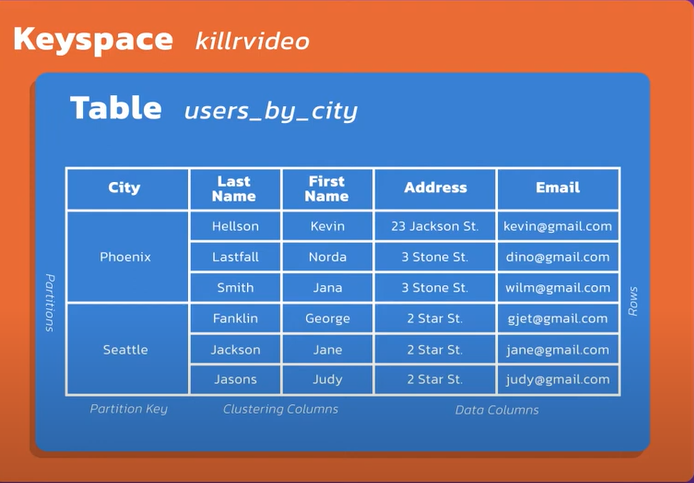
    + when a data write request comes in, a node will handle the request. This node is called coordinate node. Any node can be a coordinate node and handle the request
      + coordinate node finds the nodes that will store the data, depending on the hashed value of the partition key and the RF, and will send the copies of the data to the corresponding node
    + when a node is down, cassandra keeps a hint that will allow the data to be played back and healed or restored after the node is back
* consistency
  + Write Consistency Level (CL) = QUORUM which means majority. In the case of a replication factor of 3, the majority is 2 nodes
    + this means with a RF of 3 using quorum, cassandra will wait for an acknowledgement from two nodes before saying the write is OK and sending the results back to the client 
    + if the consistency level cannot be reached for an operation, the operation will fail
  + Read CL = QUORUM  
    + client makes the request, the coordinator reads from 2 nodes and the result is sent back to the client  
  + it doesn't matter which two nodes are consistent or if one node has the stale data. Cassandra will repair the stale data and send back the correct results
  + if both read and write using quorum CL, we call immediate consistency, meaning that I can immeidately read what I jsut wrote anywhere in my cluster
    + this is a standard and balances performance, availability and consistency 
* Use case
  + if we have several data centers in a global database around the world
    + if I write a data to the data center in U.S. the data is automatically copied to other centers, which allows me to read data from any of the data centers around the world with the lowest latency
    

### tables
* Structure of Cassandra database
  + it is a tabular data model
  + tables are organized in rows and columns
  + groups of releated rows called partitions are stored together on the same node (or nodes)
  + each row contains a partition key
* name convention: users_by_city
  + each row contains information about a user
  + rows(here are users) are partitioned by city
  + city column is the partition key
  + this table contains two physical partitions. When querying all rows from the table, two partitions will be scanned
  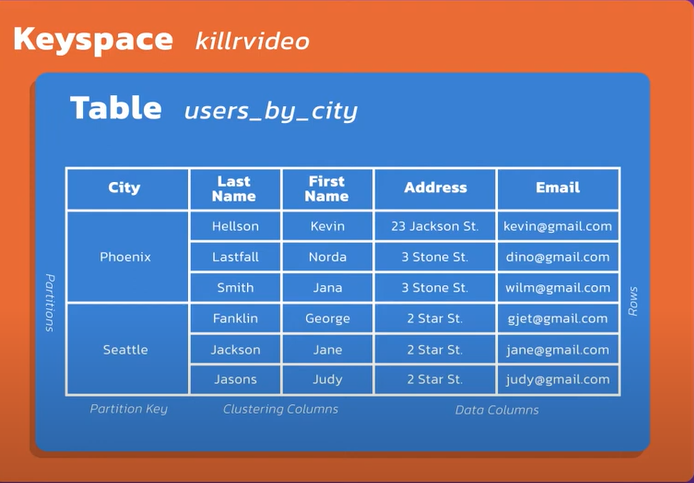
* columns of table
  + we can use clutering columns in each partition to ensure the uniqueness of each row (combination of partition key and clustering columns should be unique)
  + the clustering column(s) is used to order the rows when the data is written to the table
  + columns that are not partition key or clustering columns are called data columns
* primary key
  + enusre the uniqueness of each row. May define sorting
  + you need to have at least one partition key, followed by clustering columns
  + for two rows with identical primary keys, the last write will overwrite the previous records
  + you include the partition keys in parenthesis in primary key statement
  `PRIMARY KEY ((city), last_name, first_name, email)`
* partition key and clustering column
  + partition key is used to partition the rows
  + clustering columns are used for sorting and uniqueness
  + in the following code, video rows will be partitioned by video id, sorted by creation time, and uniquely identified by comment id              
  `PRIMARY KEY ((viedo_id), created_at, comment_id);`
  
### Rules of a good partition  
* when designing partition key, you should store what you retrieve together. In the following example 
    + in the first PK statement, video id is used as partition key so that all comments of that video will be stored and retrieved from the same partition and sorted by creation time
    + in the second PK statement, records are partitioned by comment_id, so to retrieve the comments of a video, many partitions will have to be scanned and it is not a good practice.
    ```sql
    PRIMARY KEY ((video_id), created_at, comment_id);
    PRIMARY KEY ((comment_id), created_at);
    ```
* avoid big partitions (< 100 K rows each partition)
  + in the following code example, we should partition by video id, rahter than country, since partition by country will lead to all recordes of a country to be stored in one partition, leading to big partitions
  ```sql
  PRIMARY KEY ((video_id), created_at, comment_id);
  PRIMARY KEY ((country), user_id);
  ```
* avoid unbounded partitions
  + example: 
    + A huge LOT infrastructure, hardware all over the world, differnt sensors reporting their status every 10 seconds.
    + every sensor reports its UUID, timestamp of the report, sensor' value
    + `PRIMARY KEY ((sensor_id), reported_at);`
  + problem
    + the data volume will increase unbounded 
    + the size of the partition will increase dramatically without boundary
  + solution
    + you need to cap the limit of the partition size by bucketing data in each month to each partition
    + we can still use the reported time as clustering column to sort the record within each partition
    + `PRIMARY KEY ((sensor_id, month_year), reported_at);`
  
* avoid hot partitions
  + one partition is really getting hit compared to others
  + unbalanced cluster with just a subset of noeds that process all operations and requests
  
### Data Modeling

#### Normalization
* The process of structuring a relational database in accordance with a series of so-call normal forms in oreder to reduce data redundancy and improve data integrity
* only have one single instance for each entity and associate them by foreign keys to query
* advantages
  + simple write
  + data integrity
* disadvantages
  + slow read
  + complex queries
* relational data modeling (start from data)
  + analyze raw data
  + identify entities, their properties and relations
  + desing tables, using normalization and foreign keys
  + use JSON when doing queries to join normalized data from multiple tables
  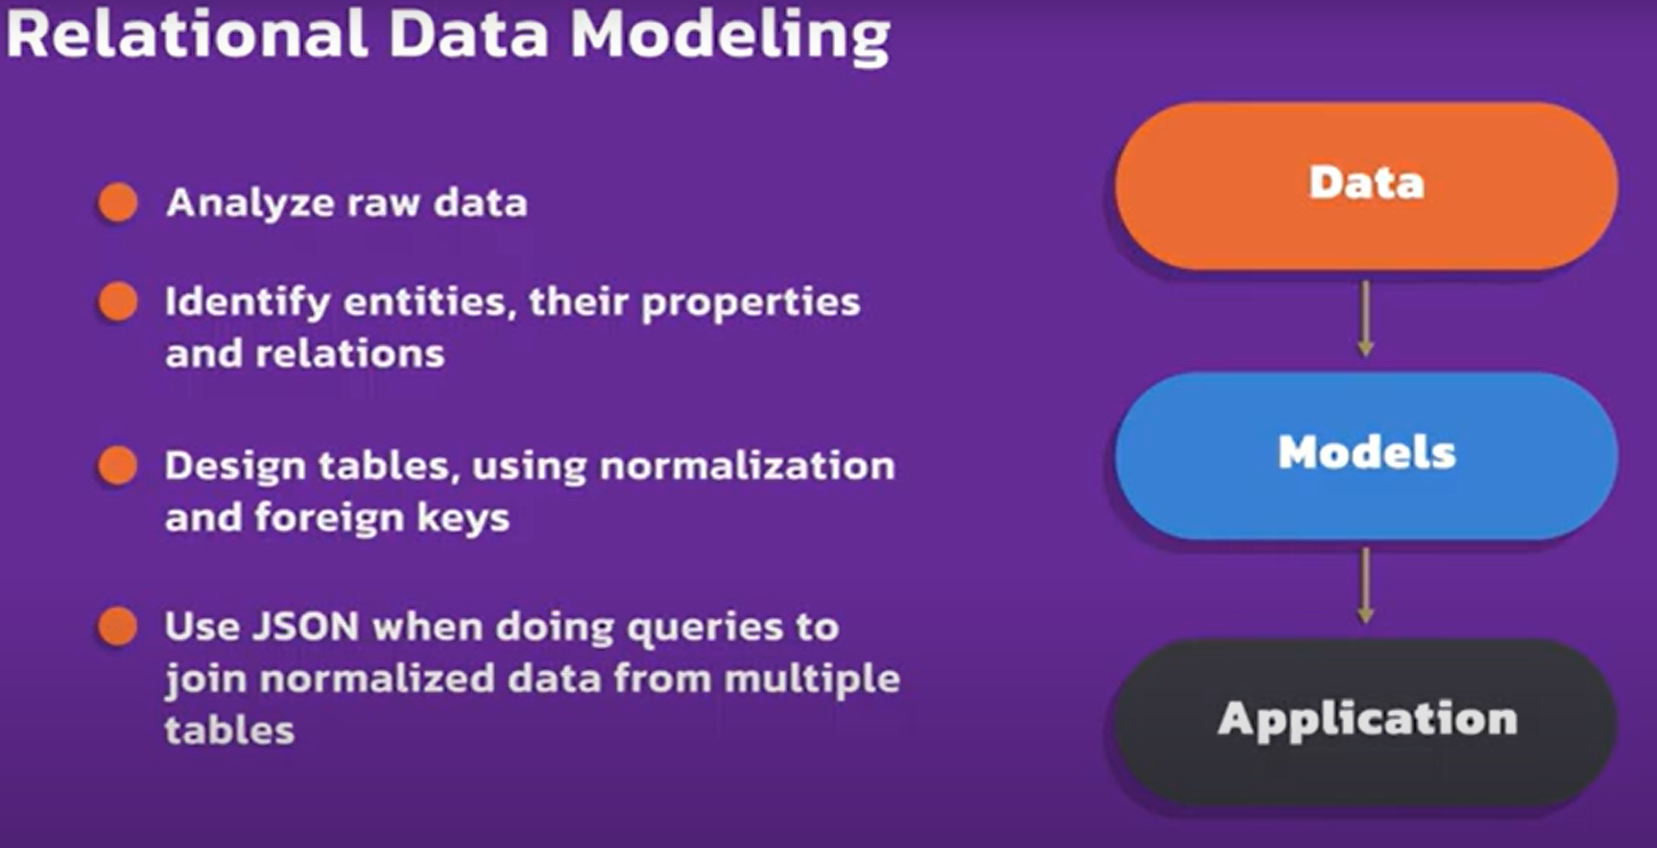
  
#### Denormalization
* A strategy used on a database to increase read performance, at the expense of losing some write performance, by adding redundant copies of data
* advantages
  + quick read
  + simple queries
* disadvantages
  + multiple writes (to multiple tables and updates)
  + manual integrity
* NoSQL data modeling (start from application)
  + analyze user behavior (customer first)
  + identify workflows, their dependencies and needs
  + define queries to fulfill these workflows
  + knowing the queries, design tables, using denormalization
  + use BATCh when inserting or updating denormalized data of multiple tables
  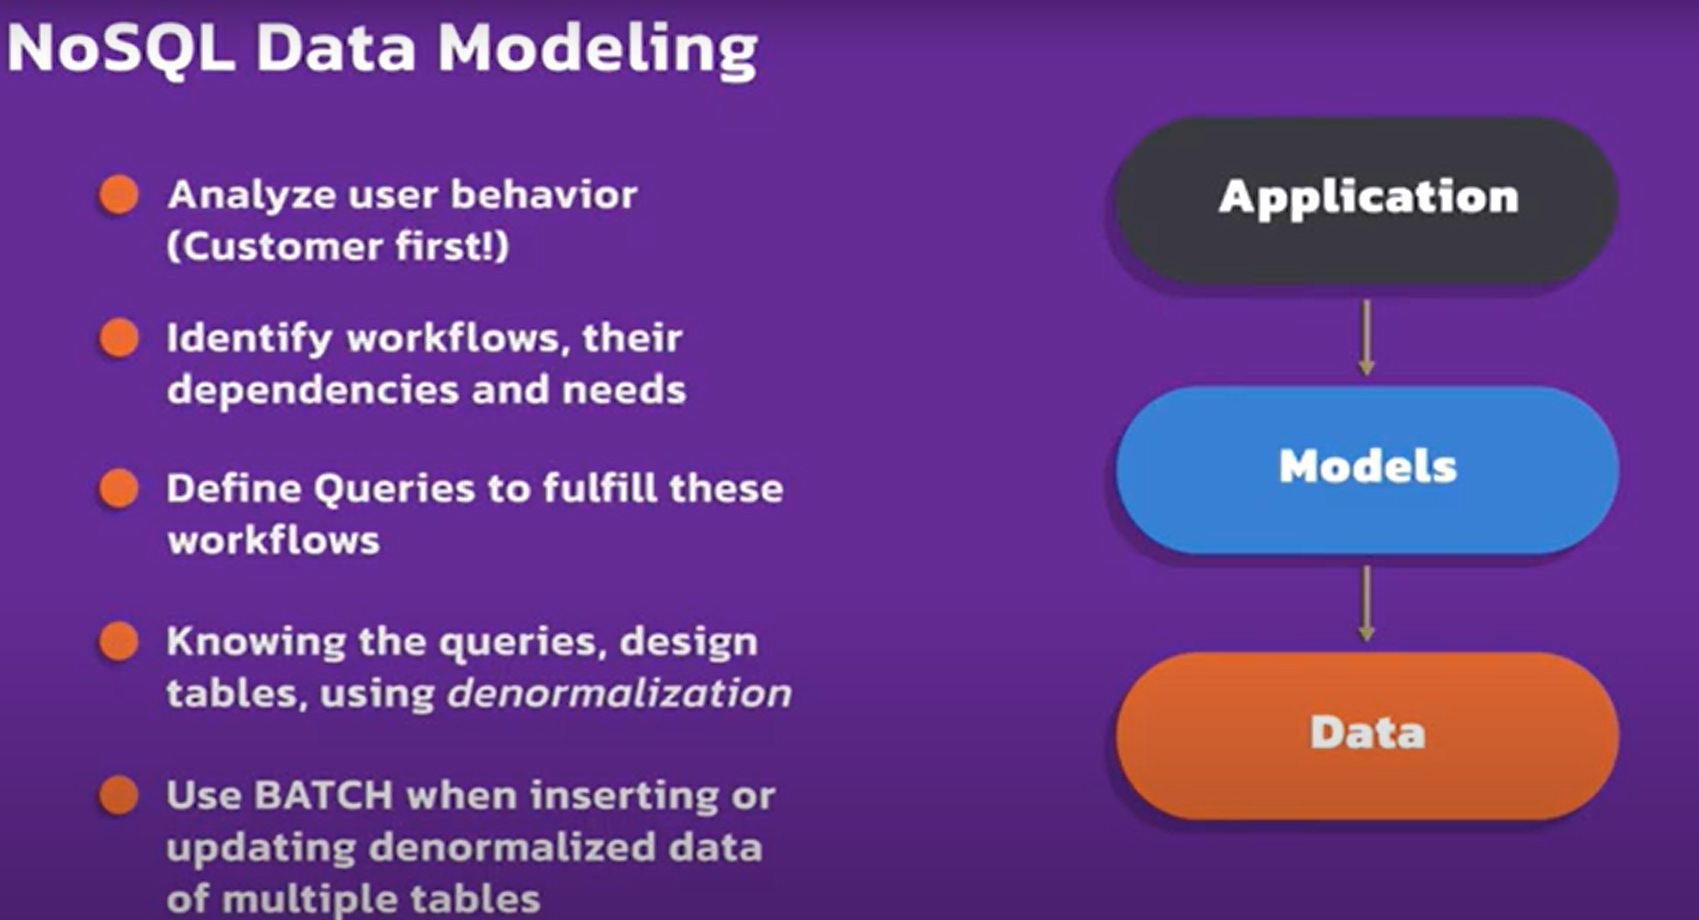
  
#### An example of data modeling and table design
* we have the ERD to define the relationship between users and videos that are joined by the comment table for the comments from each user on each video
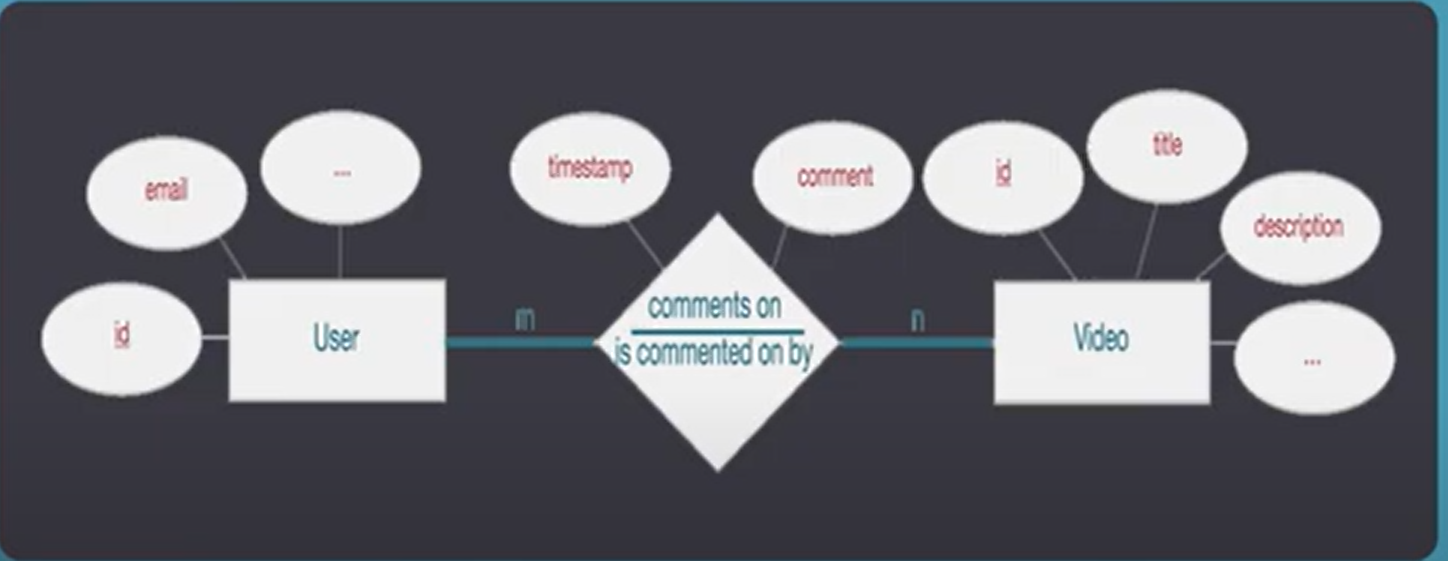

* the first step is to identify the data access patterns, as the two queries shown in the following diagram
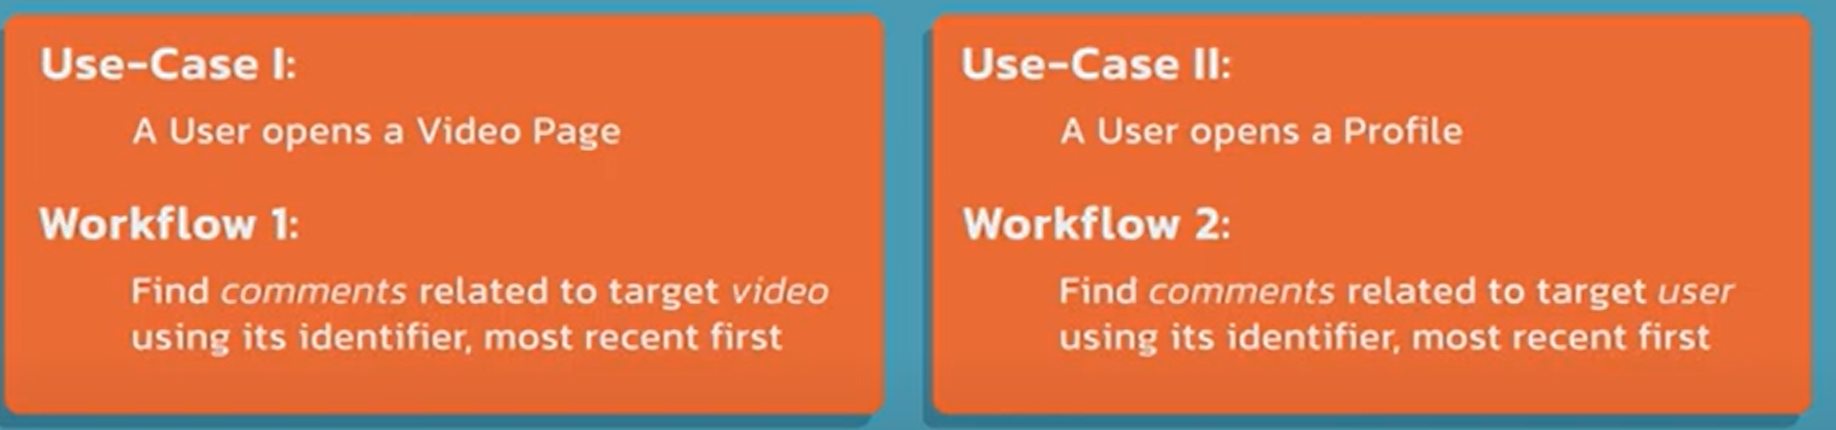

* Generate queries and the corresponding tables, each for one query
  + For query 1
    + write a psudo code for query 1:
      + Find comments posted for a user with a known id by showing the most recent first 
    + define the corresponding table for query 1 
      + comments\_by\_user (name convention: payload\_by\_partition key)
    + generate the query                             
     `SELECT * FROM comments_by_user WHERE userid = <some UUID>;`
    
  + For query 2
    + write a psudo code for query 2:
      + find comments for a video with a known id by showing the most recent first
    + define the corresponding table for query 2
      + comments\_by\_video
    + generate the query                                
    `SELECT * FROM comments_by_video WHERE video_id = <some UUID>;`
      
* Generate the logical data model for query 1 and query 2, as shown in the following diagram
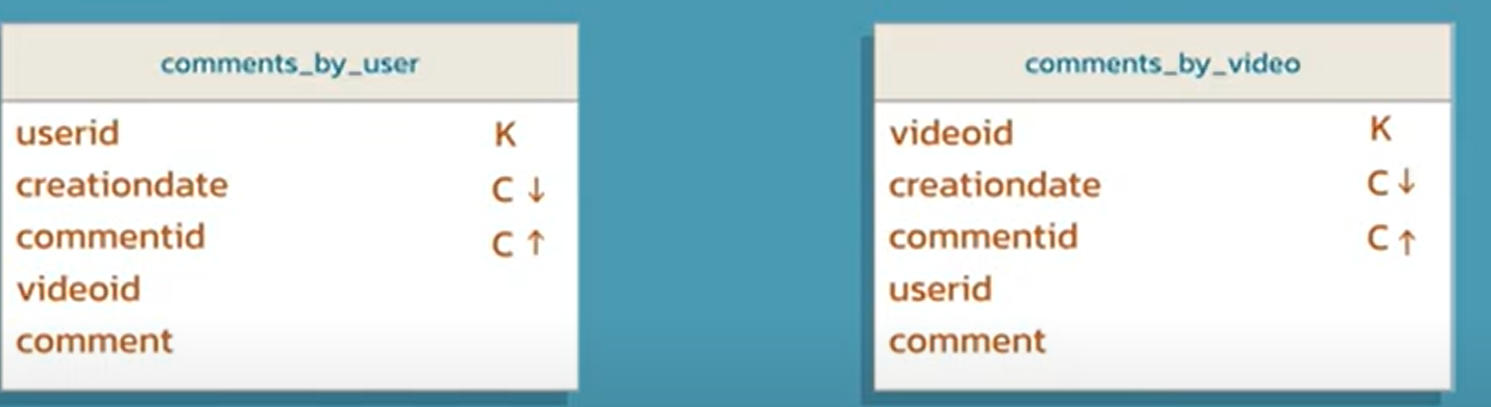

* Generate the physical data models, as shown below:
  + we combine the creation date and comment id to commentid with TIMEUUID data type as an optimization
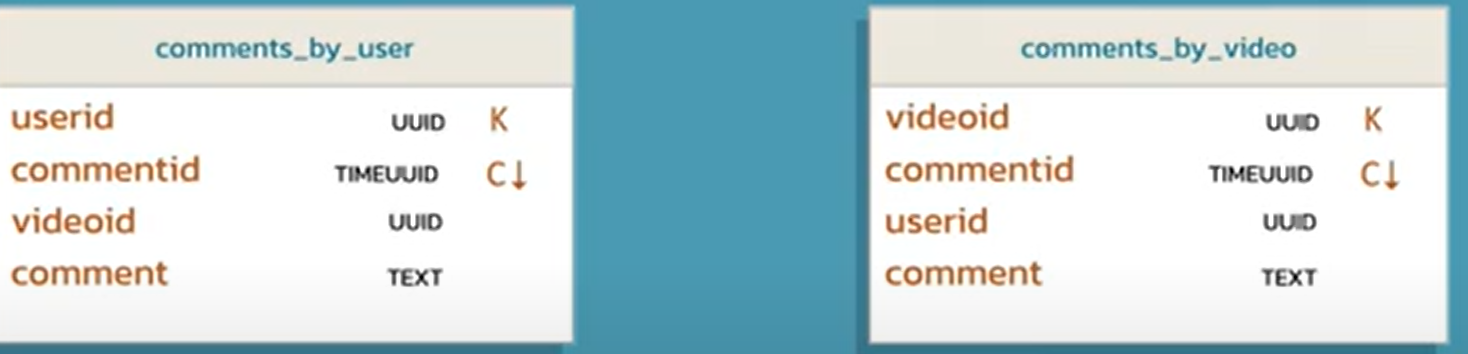

* Create tables as below:
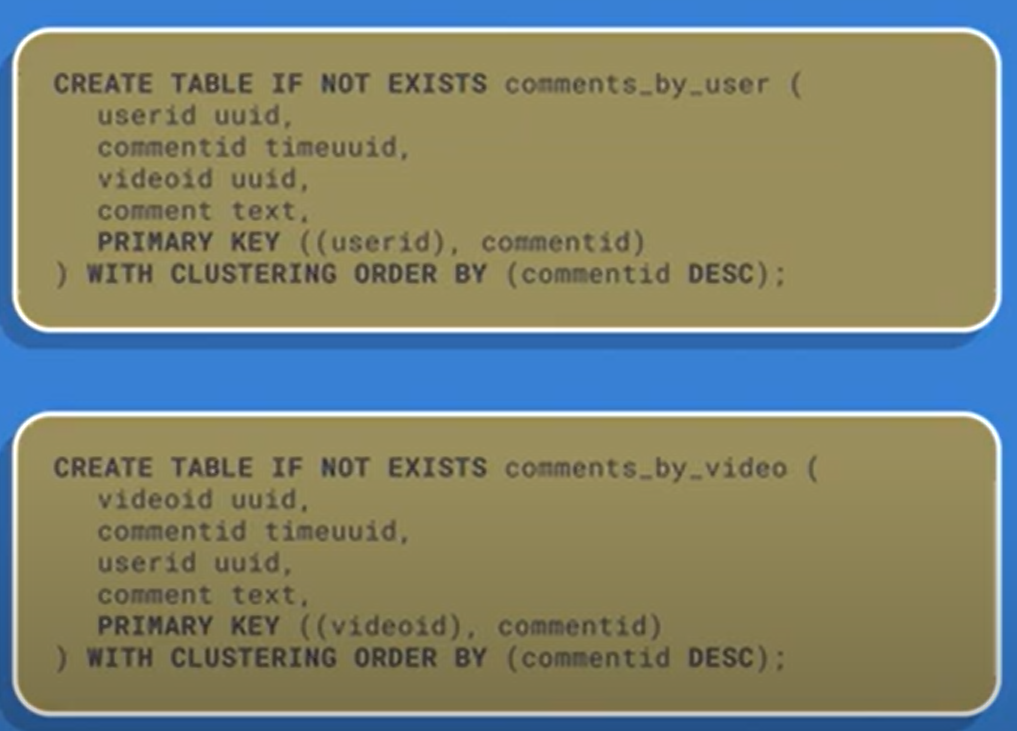

* when query, you don't need to order the data and just retrieve the entire partition  

### Practice on Astra
* create database in Astra by specifying keyspace and database name
* click CQL console from the web UI of Astra, and show all the keyspace by
`desc KEYSPACES;`
* create the table 
```sql
CREATE TABLE IF NOT EXISTS users_by_city (
    city text,
    last_name text,
    first_name text,
    address text,
    email text,
    PRIMARY KEY ((city), last_name, first_name, email));
```    
* list tables by         
`desc tables;`

* insert data by
```sql
INSERT INTO table_name (col1, col2, col3) 
VALUES (value1, value2, value3);
```
* query by SELECT
  + never do a full scan. Always use a partition key in the where clause to focus on specific partition(s)
```sql
SELECT * FROM comments_by_user WHERE userid = 1111-1111
```

* Update a record
  + you need the primary key to update a record. The partition and clustering columns need to be defined in WHERE clause
  ```sql
  UPDATE comments_by_video
  SET comment = 'OMG that guy Patrick is on fleek'
  WHERE videoid = 12345-111 AND commentid = 494a3;
  ```
* Delete a record
  + In cassandra, delete is an insert
  + delete the bigger unit (truncate table, delete the entire partition, and then a subset of partition)
  + specify the entire primary key to delete specific rows. If you only specify the partition key in WHERE clause, the entire partition will be deleted
  ```sql
  DELETE FROM comments_by_videl
  WHERE videoid = 12345 AND commentid = 494a3
```

### Useful links
* Academy.datastax.com
* datastax.com/dev
* community.datastax.com
* Datastax Developers YouTube Channel